In [2]:
# import random
# import re
# import numpy as np
# import tensorflow as tf
from skimage.transform import resize
# from skimage import measure
# from skimage.measure import regionprops
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, shannon_entropy
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.io import imread

import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

from CarPlate import GetPlate 

(1944, 2592)


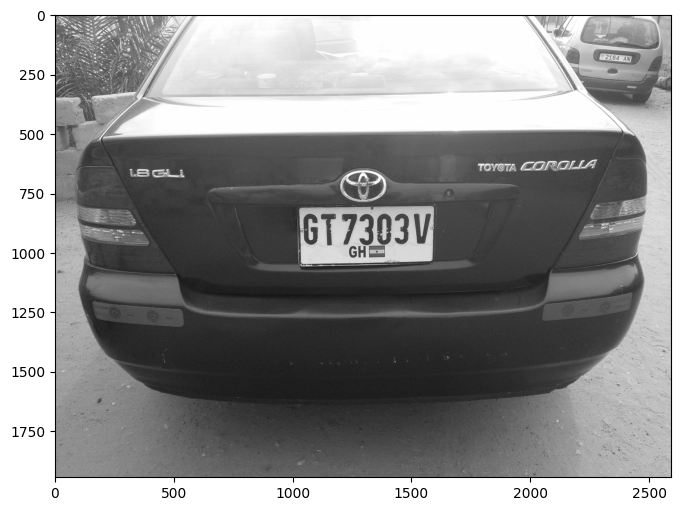

In [3]:
# car_image = imread('../data_jpg/05.jpeg', as_gray=True)
# car_image = imread('whitecar.png', as_gray=True)
# car_image = imread('../data/d12.png', as_gray=True)
car_image = imread('../data/09.jpg', as_gray=True)
print(car_image.shape)
# print(shannon_entropy(car_image))

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(car_image, cmap="gray")
plt.show()

In [4]:
plate_objects = GetPlate(car_image, False)
print(f"total plates: {len(plate_objects)}, plate[0]: {plate_objects[0].shape}")

total plates: 1, plate[0]: (246, 568)


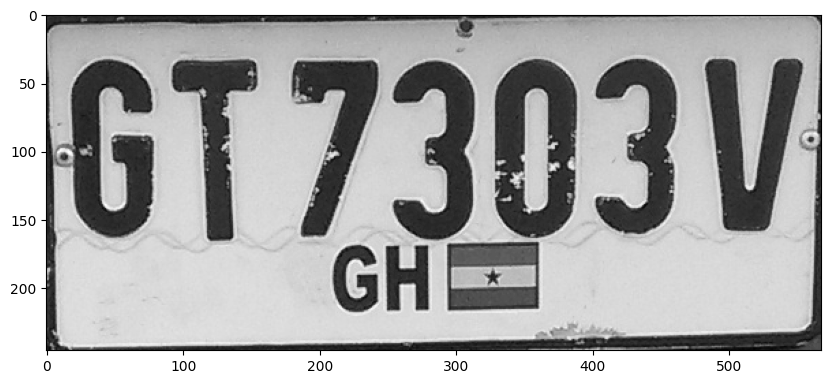

In [5]:
image = plate_objects[0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image, cmap="gray")
# ax.set_axis_off()
plt.show()

In [6]:
# text = pytesseract.image_to_string(image, lang="eng")
# print(f"{len(text)=};  text='{text}'")

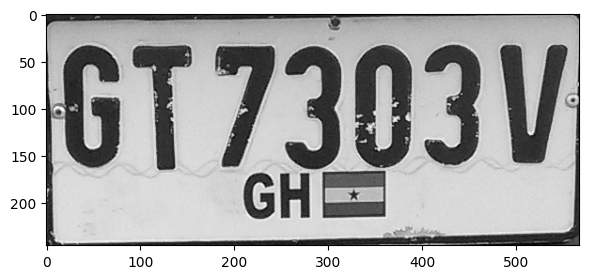

In [7]:
# def GetChars(image, show = False):
# plate = cv2.resize(image, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
plate = image
thresh = threshold_otsu(plate)

fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(plate, cmap="gray")
# ax.set_axis_off()
plt.show()

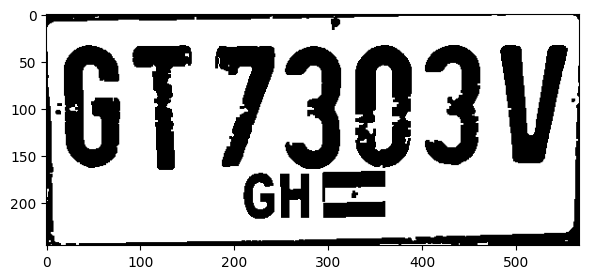

In [8]:
bw = closing(plate > thresh, square(3))

fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(bw, cmap="gray")
# ax.set_axis_off()
plt.show()

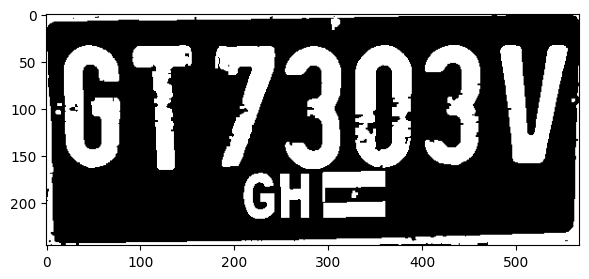

In [9]:
# cleared = clear_border(bw)
# cv2.bitwise_not(bw, cleared)
invert = 255 - bw
# invert = 255 - plate

fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(invert, cmap="gray")
# ax.set_axis_off()
plt.show()

# regionprops

In [10]:
# label_img = label(img, connectivity=img.ndim)
label_image = label(invert)
# label_image = label(cleared)
print(f"{plate.shape=}  {label_image.shape=}")

regions = [region for region in regionprops(label_image)]
print(f"total regions: {len(regions)}")

plate.shape=(246, 568)  label_image.shape=(246, 568)
total regions: 41


In [11]:
for r in regions:
    y0, x0, y1, x1 = r.bbox
    region_height = y1 - y0
    region_width = x1 - x0
    print(f"{x0=:3} : {x1=:3} ,  {y0=:3} : {y1=:3} | {region_height=:3}  {region_width=:3} | {r.area:7}")

x0=  0 : x1=474 ,  y0=  0 : y1= 17 | region_height= 17  region_width=474 |  2403.0
x0=  0 : x1=568 ,  y0=  0 : y1=246 | region_height=246  region_width=568 | 95896.0
x0=480 : x1=489 ,  y0=  0 : y1=  2 | region_height=  2  region_width=  9 |    18.0
x0=561 : x1=568 ,  y0=  0 : y1=  6 | region_height=  6  region_width=  7 |    26.0
x0= 52 : x1= 56 ,  y0=  2 : y1=  4 | region_height=  2  region_width=  4 |     5.0
x0=306 : x1=307 ,  y0=  2 : y1=  3 | region_height=  1  region_width=  1 |     1.0
x0= 29 : x1= 30 ,  y0=  4 : y1=  5 | region_height=  1  region_width=  1 |     1.0
x0= 19 : x1= 79 ,  y0= 33 : y1=164 | region_height=131  region_width= 60 |  5047.0
x0= 92 : x1=155 ,  y0= 33 : y1=166 | region_height=133  region_width= 63 |  3308.0
x0=329 : x1=389 ,  y0= 33 : y1=164 | region_height=131  region_width= 60 |  5096.0
x0=403 : x1=462 ,  y0= 33 : y1=161 | region_height=128  region_width= 59 |  3821.0
x0=483 : x1=555 ,  y0= 33 : y1=159 | region_height=126  region_width= 72 |  4767.0
x0=1

In [12]:
min_height, max_height = 0.5*plate.shape[0], 0.98*plate.shape[0]
# min_height, max_height = 0.75*plate.shape[0], 0.98*plate.shape[0]
min_width,  max_width  = 0.05*plate.shape[1], 0.15*plate.shape[1]
print(f"{min_height=}  {max_height=}  |  {min_width=}  {max_width=}  | min area={min_height * min_width}")

min_height=123.0  max_height=241.07999999999998  |  min_width=28.400000000000002  max_width=85.2  | min area=3493.2000000000003


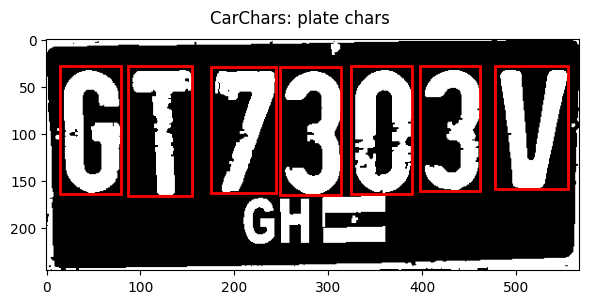

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 3))
fig.suptitle("CarChars: plate chars")
ax1.imshow(invert, cmap="gray")

characters = []
column_list = []
delta = 5
for r in regions:
    if r.area < 40: 
        continue
    y0, x0, y1, x1 = r.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if (min_height < region_height < max_height) and (min_width < region_width < max_width): ## !!! ERROR: MUST Chaige IF ...
        # rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red", linewidth=2, fill=False)
        # rect_border = patches.Rectangle((x0, y0), region_width, region_height, edgecolor="red", linewidth=2, fill=False)
        rect_border = patches.Rectangle((x0-delta, y0-delta), region_width+delta, region_height+delta, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # roi = invert[y0-delta:y1+delta, x0-delta:x1+delta]  # error
        roi = invert[y0:y1, x0:x1]
        resized_char = 255 - resize(roi, (20, 20))
        # resized_char = resize(roi, (20, 20))
        characters.append(resized_char)
        column_list.append(x0)

plt.show()

In [14]:
print(f"characters: {len(characters)},  columns: {column_list}")

characters: 7,  columns: [19, 92, 329, 403, 483, 180, 254]


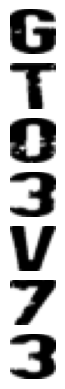

In [15]:
for i in range(len(characters)):
    plt.subplot(len(characters), 1,  i+1)
    # plt.subplot( 1, len(characters), i+1)
    plt.imshow(characters[i], cmap='gray')
    plt.axis('off')
plt.show()    

# 